# Data

In [659]:
import gzip
import os
import sys
import struct
import numpy as np
def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

In [33]:
data = np.load('mnist.npz')
X_train = data['train_x']
y_train = data['train_y']
X_test = data['test_x']
y_test = data['test_y']

# 1-D Image 확장
0~1 값을 가지는 `28x28` size MNIST 데이터셋을, 임의의 background 이미지와 합성해 random color를 가지는 `28x28x3` 이미지로 만들어준다.

In [660]:
'''
Image를 출력해주는 함수
'''
from matplotlib import pyplot as plt
def print_image(img) :
    plt.imshow(img)
    plt.show()

In [661]:
'''
background 이미지를 road하는 함수
'''
import PIL.Image as pilimg 
def load_background() :
    backgrounds = []
    file_list = os.listdir('./background')
    for file in file_list :
        output = pilimg.open('./background/{}'.format(file))
        output = np.array(output).sum(axis = 2)
        output = 1-(output - output.min()) / (output.max() - output.min())
        backgrounds.append(output)
    return backgrounds

## 이미지 확장
1-D 이미지는 0~1 사이의 값을 가진다. 역으로 생각해보면 원본 이미지의 채널 3개를 합친 후 min-max scale을 해주면 MNIST데이터셋이 만들어진다라고 생각할 수 있다. 따라서 MNIST이미지를 inverse min-max scale을 해주면 color이미지를 만들 수 있겠다고 생각을 했다.
> 각 채널의 min, max값은 0~255사이의 값을 무작위로 출력해주는 uniform distribution에서 뽑아온다.  
> `원본이미지(max-min) + min`공식을 이용해 inverse scaling 해준다.  
> background + MNIST 해서 이미지를 합쳐준다.
> * MNIST데이터를 돋보이게 하기위해 background와 MNIST의 데이터가 겹칠 경우 MNIST 픽셀을 우선적으로 적용시킨다.

In [662]:
'''
img : MNIST image
figures : backgrounds
'''
def make_rgb(img, figures) :
    rgbs = []
    for figure in figures :
        rgb = np.zeros((28, 28, 3))
        for i in range(3) :
            a, b, c, d = np.random.uniform(low=0, high=255, size=4)
            n = np.where(img != 0, img*(max(a, b) - min(a, b)) + min(a, b), 0) # single channel MNIST Image
            f = figure*(max(c, d) - min(c, d)) + min(c, d) # single channel background
            output = np.where(n+f == f, n+f, n) # 겹치지 않으면 MNIST + background, 겹치면 MNIST
            rgb[:,: , i] += output 
        rgbs.append(rgb.astype(np.uint8))
    return rgbs

## 적용

In [663]:
# background 이미지 불러오기
figures = load_background()

In [664]:
# X_train(60000, 28, 28)에 적용
X_train_arguments = []
for img in X_train :
    X_train_arguments += make_rgb(img, figures)
X_train_arguments = np.array(X_train_arguments)

In [665]:
# 적용 후 데이터셋
X_train_arguments.shape

(360000, 28, 28, 3)

In [666]:
y_train_arguments = []
for y in y_train :
    y_train_arguments += [y]*6
y_train_arguments = np.array(y_train_arguments)

In [667]:
y_train_arguments.shape

(360000,)

## 확장한 Samples print

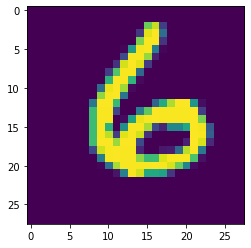

In [668]:
# original image
img = X_train[2093]
print_image(img)

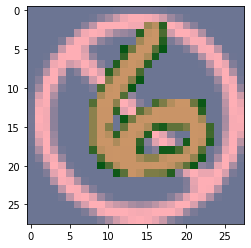

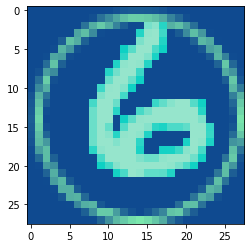

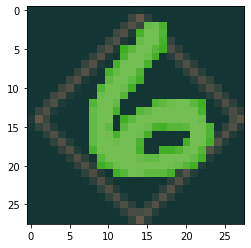

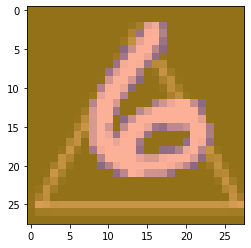

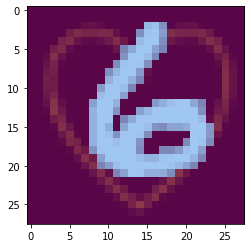

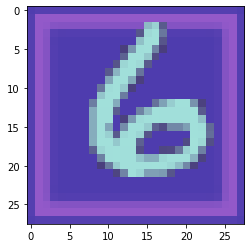

In [669]:
# expanded image
rgbs = make_rgb(img, figures)
for rgb in rgbs :
    print_image(rgb)

# Data Argumentation
[참조 사이트](https://github.com/aleju/imgaug)

먼저 `imgaug`를 설치해줘야한다. [설치방법](https://github.com/aleju/imgaug#installation) 에 자세히 나와있다.

In [ ]:
# 설치
!pip install imgaug

In [675]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

# random example images
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
images_aug = seq(images=X_train_arguments)

In [676]:
images_aug.shape

(360000, 28, 28, 3)

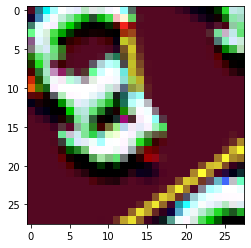

original label : 3


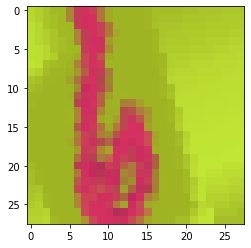

original label : 6


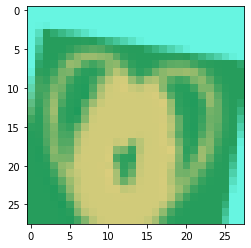

original label : 0


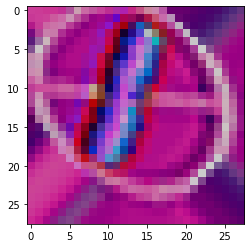

original label : 1


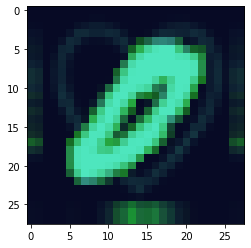

original label : 0


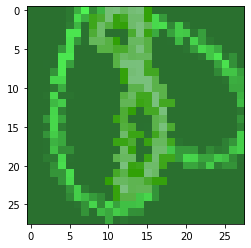

original label : 8


In [681]:
idx = np.random.randint(360000, size=6)
for rgb, i in zip(images_aug[idx], idx) :
    print_image(rgb)
    print('original label :',y_train_arguments[i])

In [690]:
data_X = np.vstack([X_train_arguments, images_aug])
data_y = np.hstack([y_train_arguments, y_train_arguments])

In [691]:
print('X shape : ', data_X.shape)
print('y shape : ', data_y.shape)

X shape :  (720000, 28, 28, 3)
y shape :  (720000,)


# 마치며
기존 train 데이터셋 60000개에서 -> 720000개로 만들었기 때문에 test 데이터까지는 굳이 안해도 충분히 많은 데이터라고 생각되서 하지 않았다.  
csv파일은
* X_train : (504000, 28x28x3)
* X_test : (216000, 28x28x3)
* y_train : (504000)
* y_test : (216000)

이고 불러올 때는
```python

X_train = pd.read_csv([X_train_FILE_PATH])
X_test = pd.read_csv([X_test_FILE_PATH])
y_train = pd.read_csv([y_train_FILE_PATH])
y_test = pd.read_csv([y_test_FILE_PATH])

X_train = np.reshape(X_train, (-1, 28, 28, 3))
X_test = np.reshape(X_test, (-1, 28, 28, 3))
```
로 불러오면 될듯 싶다.
* 불러오는건 안해봄. 그냥 csv파일 읽어와서 reshape해주면 됨.

## Train, Test split

In [696]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    shuffle = True,
                                                    stratify = data_y)

## 이미지 출력

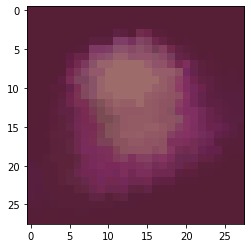

original label : 2


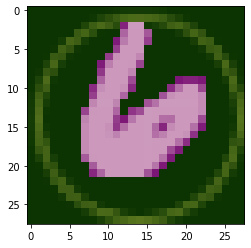

original label : 6


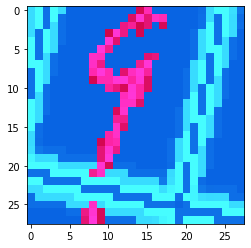

original label : 9


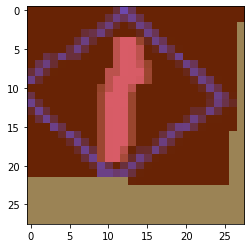

original label : 1


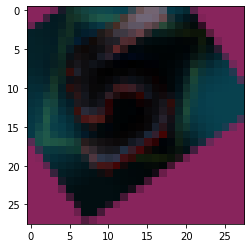

original label : 5


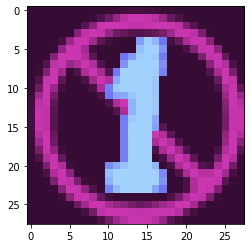

original label : 1


In [697]:
idx = np.random.randint(len(X_train), size=6)
for rgb, i in zip(X_train[idx], idx) :
    print_image(rgb)
    print('original label :',y_train[i])

In [701]:
# 데이터 csv파일로 내보내기
import pandas as pd
pd.DataFrame(X_train.reshape(len(X_train), -1)).to_csv('X_train', index = False)
pd.DataFrame(X_test.reshape(len(X_test), -1)).to_csv('X_test', index = False)
pd.DataFrame(y_train).to_csv('y_train', index = False)
pd.DataFrame(y_test).to_csv('y_test', index = False)